In [1]:
# <AUTOGEN_PATH_SETUP>
# Ensure project root is on import path & set CWD
import sys
import os
from pathlib import Path

cwd = Path.cwd().resolve()
if "notebooks" in cwd.parts:
    root = Path(*cwd.parts[: cwd.parts.index("notebooks")])
else:
    root = cwd.parent
if str(root) not in sys.path:
    sys.path.insert(0, str(root))
os.chdir(root)
print("Project root:", root)

Project root: /Users/wadoudcharbak/Documents/GitHub/Quant_Project/Equity_Factor_Alpha


# 00 End‑to‑End Pipeline Demo
This notebook mirrors **`run_efa.py`** step‑by‑step so you can run, inspect, and tweak each stage interactively.

In [2]:
from pathlib import Path
import logging

from src.config import cfg
from src.data_loader import get_all_equities
from src.features import add_returns, add_rolling_features, prepare_feature_matrix
from src.model import train_model, predict
from src.backtest import run_backtest
from src.plotting import plot_equity

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s | %(levelname)s | %(message)s"
)
logger = logging.getLogger(__name__)

## 1 – Load configuration

In [3]:
p = cfg()
p

{'project': {'name': 'Equity Factor Alpha Engine', 'version': '0.1.0'},
 'base_currency': 'GBP',
 'assets': [{'ticker': 'AAPL'},
  {'ticker': 'MSFT'},
  {'ticker': 'GOOGL'},
  {'ticker': 'AMZN'},
  {'ticker': 'NVDA'},
  {'ticker': 'ROO'},
  {'ticker': 'ITV'}],
 'start_date': '2023-10-01',
 'end_date': None,
 'features': {'return_col': 'returns', 'windows': [5, 20, 60]},
 'model': {'objective': 'reg:squarederror',
  'max_depth': 3,
  'learning_rate': 0.1,
  'n_estimators': 200,
  'subsample': 0.8,
  'colsample_bytree': 0.8},
 'backtest': {'hold_days': 5,
  'top_n': 2,
  'notional': 1000,
  'fee_bps': 0.0,
  'risk_free_rate': 0.0},
 'paths': {'data_raw': 'data_raw',
  'data_proc': 'data_proc',
  'outputs': 'outputs',
  'logs': 'logs'}}

## 2 – Choose asset universe

In [4]:
selected_assets = [a["ticker"] for a in p["assets"]]
print("Selected assets:", selected_assets)

Selected assets: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'ROO', 'ITV']


## 3 – Download / cache price data

In [5]:
start = "2023-07-01"
end = None

data = get_all_equities(force_refresh=True, start_date=start, end_date=end)
data = {t: df for t, df in data.items() if t in selected_assets}
logger.info("Loaded price data for %d tickers", len(data))
list(data.items())[:2]  # show sample

2025-07-29 11:51:47,705 | INFO | Loaded price data for 7 tickers


[('AAPL',
                                   open        high         low       close  \
  2023-07-03 00:00:00+00:00   99.840431   99.869652   99.615715   99.728167   
  2023-07-04 00:00:00+00:00  100.427534  100.515976  100.164883  100.260322   
  2023-07-05 00:00:00+00:00  100.594492  100.954827  100.491231  100.776311   
  2023-07-06 00:00:00+00:00   99.610701   99.632835   99.497327   99.601689   
  2023-07-07 00:00:00+00:00   98.725040   98.771045   98.650208   98.735754   
  ...                               ...         ...         ...         ...   
  2024-06-24 00:00:00+00:00  111.671158  111.930175  111.474033  111.758914   
  2024-06-25 00:00:00+00:00  113.322628  113.400049  113.096154  113.293609   
  2024-06-26 00:00:00+00:00  113.283632  113.415386  113.172806  113.200042   
  2024-06-27 00:00:00+00:00  115.017886  115.031444  114.866272  114.884760   
  2024-06-28 00:00:00+00:00  114.034397  114.191244  113.488767  113.658548   
  
                                  volum

## 4 – Feature engineering

In [6]:
processed = {}
for t, df in data.items():
    df = add_returns(df, price_col="close", out_col=p["features"]["return_col"])
    df.dropna(subset=[p["features"]["return_col"]], inplace=True)
    df = add_rolling_features(
        df, col=p["features"]["return_col"], windows=p["features"]["windows"]
    )
    processed[t] = df
logger.info("Feature engineering complete.")

2025-07-29 11:51:47,728 | INFO | Feature engineering complete.


## 5 – Prepare X and y matrices

In [7]:
X, y = prepare_feature_matrix(
    processed,
    windows=p["features"]["windows"],
    lookahead=1,
    return_col=p["features"]["return_col"],
)
benchmark = y.groupby(level=0).mean()
X.head()

,,open,high,low,close,volume,returns_mean_5,returns_std_5,returns_mom_5,returns_mean_20,returns_std_20,returns_mom_20,returns_mean_60,returns_std_60,returns_mom_60
date,ticker,,,,,,,,,,,,,,
2023-09-25 00:00:00+00:00,AAPL,110.517764,110.674299,110.345890,110.598147,845.023539,0.002466,0.010235,0.012329,0.002330,0.008400,0.046609,0.001778,0.010201,0.106662
2023-09-26 00:00:00+00:00,AAPL,110.921221,111.173723,110.726371,110.966439,1607.694702,0.003891,0.009749,0.019455,0.001904,0.008118,0.038080,0.001744,0.010193,0.104656
2023-09-27 00:00:00+00:00,AAPL,112.854588,112.935009,112.634571,112.786871,1045.050761,0.003793,0.009619,0.018965,0.001985,0.008253,0.039708,0.001932,0.010356,0.115914
2023-09-28 00:00:00+00:00,AAPL,111.632688,111.645060,111.535200,111.578205,995.510520,0.002240,0.011096,0.011199,0.002017,0.008203,0.040347,0.001948,0.010336,0.116854
2023-09-29 00:00:00+00:00,AAPL,112.351428,112.539325,112.182975,112.379498,1165.096738,0.001252,0.010369,0.006261,0.002481,0.008220,0.049613,0.002212,0.010263,0.132729


## 6 – Train XGBoost model

In [8]:
model, rmse = train_model(X, y, params=p["model"], test_size=0.2)
print(f"Validation RMSE: {rmse:.6f}")

Validation RMSE: 0.016843


## 7 – Generate predictions

In [9]:
preds = predict(model, X)
preds.head()

date                       ticker
2023-09-25 00:00:00+00:00  AAPL     -0.000659
2023-09-26 00:00:00+00:00  AAPL      0.001028
2023-09-27 00:00:00+00:00  AAPL     -0.000542
2023-09-28 00:00:00+00:00  AAPL     -0.000305
2023-09-29 00:00:00+00:00  AAPL      0.001240
Name: prediction, dtype: float32

## 8 – Run back‑test

In [10]:
results = run_backtest(
    predictions=preds,
    returns=y,
    benchmark_returns=benchmark,
    risk_free_rate=p["backtest"].get("risk_free_rate", 0.0),
    hold_days=p["backtest"]["hold_days"],
    top_n=p["backtest"]["top_n"],
    notional=p["backtest"]["notional"],
    fee_bps=p["backtest"]["fee_bps"],
)
equity = results["equity"]
metrics = results["metrics"]
metrics

{'total_net_pnl': np.float64(1419.7451548626473),
 'num_trades': 936,
 'hit_rate': np.float64(0.5021367521367521),
 'avg_trade_ret': np.float64(0.0015168217466481272),
 'max_drawdown_abs': 2466.672240043912,
 'max_drawdown_pct': 0.7337338731284465,
 'sharpe': np.float64(1.3297018595858816),
 'alpha': 0.04212059236273155,
 'beta': 7.530826090763089,
 'alpha_tstat': 1.3282250394864061}

## 9 – Visualise equity curve

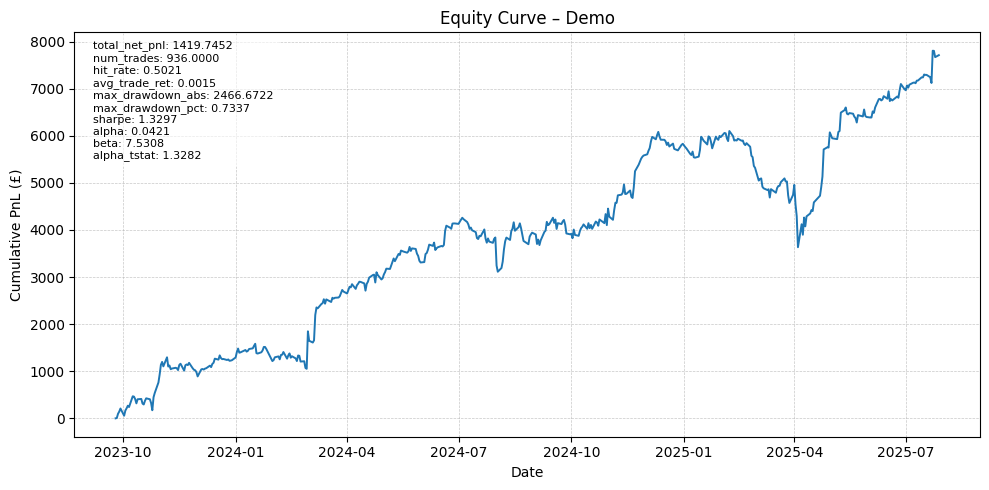

<Axes: title={'center': 'Equity Curve – Demo'}, xlabel='Date', ylabel='Cumulative PnL (£)'>

In [11]:
plot_equity(equity, title="Equity Curve – Demo", metrics=metrics)

---
### Notebook complete
You’ve now stepped through the entire `run_efa.py` workflow interactively. Feel free to tweak parameters in **`params.yaml`** and re‑run individual cells.